# Experimenting with modularity in deep learning




### Setup: import libraries

In [ ]:
import tensorflow as tf

Here I add a new cell in order to import the libraries I will use for the rest of the notebook. In addiction also a parameters dictionary for the visualization with the matplotlib library.

In [ ]:
# library for download dataset
import tensorflow_datasets as tfds

# utils
import pickle
import time 

# visualization:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# define parameters for the plotting
params_dict = {"axes.titlesize" : 24, "axes.labelsize" : 20,
               "lines.linewidth" : 4, "lines.markersize" : 10,
               "xtick.labelsize" : 16,"ytick.labelsize" : 16}

### The dataset



The **dataset** I use is the [Flower](https://www.tensorflow.org/datasets/catalog/tf_flowers) one, directly from the TensorFlow Datasets API. It consist of 3,670 images of flowers of 5 different categories. Each image is stored as a 3 dimensional tensor of int values; has 3 channel (rgb image) and they don't share the same spatial dimension. A precise visualization is taken from the documentation: 

```
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})
```

The **task** has a classification aim on the the type of flowers.



Now we can proceed with the code. In the first place I will download and prepare the dataset for the task, splitting in 70/15/15 the total ammount for build the train, validation and test set. A preprocessing step and data augmentation step is added as explained below. 

In [ ]:
# here I set a random seed for reproducibility
tf.keras.utils.set_random_seed(1)

# Now we can import the data divided in train and validation
# dataset splitted as 80%-20% of the total percentage of inputs.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True,
)

# Using the metadata we can obtain the number of classes 
num_classes = metadata.features['label'].num_classes  # 5
# also, a mapping function that takes as input a label (int) 
# and return the associated type of flower (string).
get_label_name = metadata.features['label'].int2str

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The training will be execute using 2569 samples, while the validation size count 551 images and test set 550 samples.

In [ ]:
print(f"Number of training sample: {train_ds.cardinality()}")
print(f"Number of validation sample: {val_ds.cardinality()}")
print(f"Number of test sample: {test_ds.cardinality()}")

Number of training sample: 2569
Number of validation sample: 551
Number of test sample: 550


In [ ]:
# We can define a preprocessing function with takes as input
# the pair image, label and act a resizing operation on the spatial dimension
# and rescaling the value normalizing them. 
def preprocess(image, label):
    # cast the image to float32
    image = tf.cast(image, tf.float32)
    # resize image to shape (96, 96)
    image = tf.image.resize(image, (96, 96))
    # normalize the RGB values in [0,1]
    image = image / 255.
    return image, label

# we can define also a augment function in which each image
# is randomly flip left or right
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  return image, label

# Apply the preprocess and augment function on the right dataset (validation and test doesn't have data augmentation)
# the batch size is 32 and applied only on training data for later usage. Validation batching is taken care in fit function.
batch_size = 32

train_ds_p = train_ds.map(preprocess).map(augment).shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds_p = val_ds.map(preprocess).batch(1).prefetch(tf.data.AUTOTUNE)
test_ds_p = val_ds.map(preprocess).batch(1).prefetch(tf.data.AUTOTUNE)

Here I insert a visualization over a batch of the train dataset. We can see that not every images are clean (i.e not only focusing on flowers).

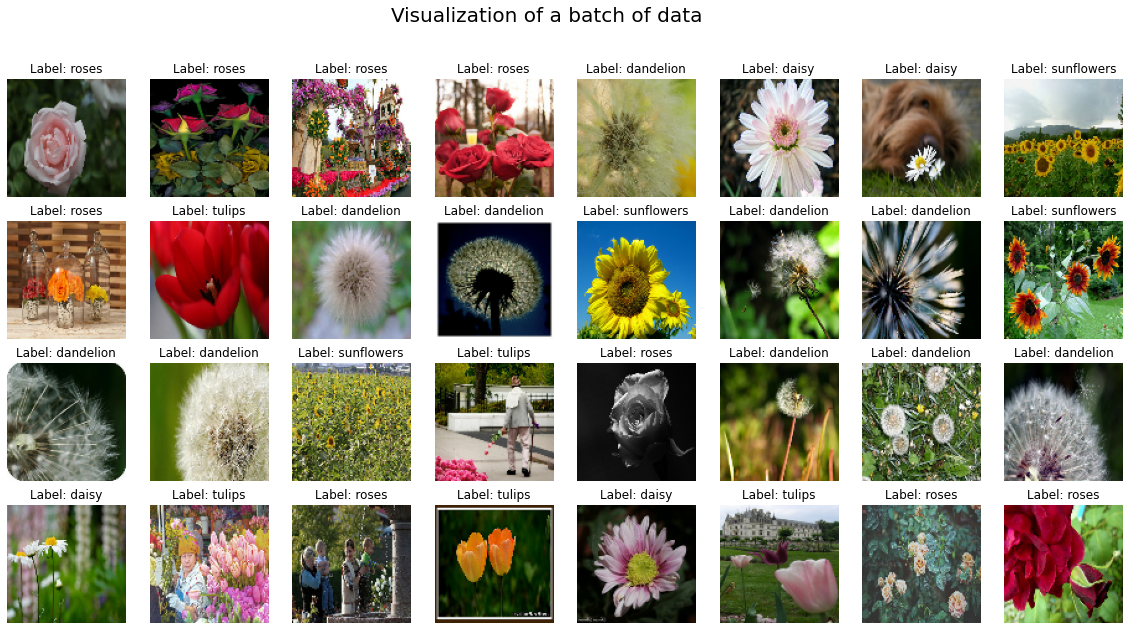

In [ ]:
# Inspect the first batch of data
for x,y in train_ds_p.take(1):
  break

# Plotting the images
plt.figure(figsize=(20, 10))
plt.suptitle('Visualization of a batch of data', fontsize = 20)
for i, (image, label) in enumerate(zip(x,y)):
  # loop for plot
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image)
  plt.title(f'Label: {get_label_name(label)}')
  plt.axis("off")

Is usefull to understand the distributions of the splitted data. Each of them are balanced.

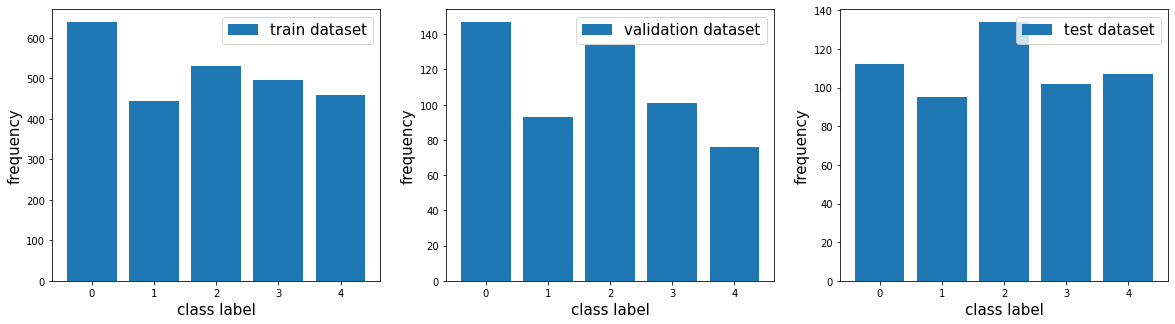

In [ ]:
# check class distribution on the training data
datasets = ['train', 'validation', 'test']
fig, axs = plt.subplots(1,3, figsize = (20,5))
for i, dataset in enumerate([train_ds, val_ds, test_ds]):
    _, y = tuple(zip(*dataset))
    val = tf.unique_with_counts(y)
    _ = axs[i].bar(tf.cast(val.y, tf.float32), val.count, label = f"{datasets[i]} dataset")
    axs[i].set_xlabel("class label", fontsize = 15)
    axs[i].set_ylabel("frequency", fontsize = 15)
    axs[i].legend(fontsize = 15);

### Train

The **model** I want to use is the **VGG11** which architecture follow the [original](https://arxiv.org/pdf/1409.1556.pdf) one. The architecture consist of blocks defined as: a sequence of 3x3 convolutional layers (with the same number of filters), than a batch normalization operation followed by a ReLU; a max-pooling 2x2 is applied at the end of the block. After the convolutional blocks we have a global pooling to pass the output to the classification block formed by 3 fully connected layers with a dropout layer in between.
Since is it used a ReLU activation function, I set the Kaiming weights as weights initializer because perform better and avoid vanishing gradient. 

The classification task is perfomed by training this model with a SGD optimizer with a momentum of 0.9 and a very low learning rate. The loss function is the usual Cross Entropy. In order to return the best model during the training I insert an EarlyStopping on the validation accuracy.




In [ ]:
def add_ConvBlock(input_shape, n_conv_layers=1, n_filters=32, name = None):
    # Function that creates a Convolutional Block to be added to the model.
    # We need to specify the number of consecutive convolutional layer, 
    # than we perform a batch normalization after each conv, 
    # than use ReLU as activation functions
    # in the end perform a MaxPooling operation.
    inp = tf.keras.layers.Input(shape=input_shape)
    
    x = inp
    for i in range(n_conv_layers):
        x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', 
                                   kernel_initializer = tf.keras.initializers.he_uniform)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
    out = tf.keras.layers.MaxPool2D()(x)
    # return the Model
    return tf.keras.Model(inputs = [inp], outputs = [out], name=f"{name}") 

In [ ]:
class VGGnet11(tf.keras.Model):
    "Class for the model VGGNET11 implemented using Keras Subclassing API"
    def __init__(self, num_classes, input_shape=(96, 96, 3)):
        super(VGGnet11, self).__init__()

        # initialize the layer of the architecture
        self.conv_blocks = [
                add_ConvBlock(input_shape, n_conv_layers = 1, n_filters = 64, name="conv_block1"),
                add_ConvBlock((48, 48, 64), n_conv_layers = 1, n_filters = 128, name="conv_block2"),
                add_ConvBlock((24, 24, 128), n_conv_layers = 2, n_filters = 256, name="conv_block3"),
                add_ConvBlock((12, 12, 256), n_conv_layers = 2, n_filters = 512, name="conv_block4"),
                add_ConvBlock((6, 6, 512), n_conv_layers = 2, n_filters = 512, name="conv_block5")
              ]
                   
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.fc1 = tf.keras.layers.Dense(4096, activation='relu', kernel_initializer = tf.keras.initializers.he_uniform)  
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(4096, activation='relu', kernel_initializer = tf.keras.initializers.he_uniform) 
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.classification = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=False):
        
        for conv_block in self.conv_blocks:
            x = conv_block(x, training=training)
           
        x = self.global_pool(x)
        x = self.dropout1(self.fc1(x), training = training)
        x = self.dropout2(self.fc2(x), training = training)
        return self.classification(x)   

    # override summary printing
    def summary(self):
        x = tf.keras.layers.Input(shape=(96,96,3))
        model = tf.keras.Model(inputs=[x], outputs=self.call(x), name = "VGGNET11")
        return model.summary()    

In [ ]:
# define compile object such metrics, loss and optimizer
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)

def create_model():
    # clean the model creation
    tf.keras.backend.clear_session()
    # instantiate the model and compile it
    model = VGGnet11(num_classes)
    model.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy])
    return model

In [ ]:
# ----------- MODEL -------------------
vggnet11 = create_model()
vggnet11.summary()

Model: "VGGNET11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv_block1 (Functional)    (None, 48, 48, 64)        2048      
                                                                 
 conv_block2 (Functional)    (None, 24, 24, 128)       74368     
                                                                 
 conv_block3 (Functional)    (None, 12, 12, 256)       887296    
                                                                 
 conv_block4 (Functional)    (None, 6, 6, 512)         3544064   
                                                                 
 conv_block5 (Functional)    (None, 3, 3, 512)         4723712   
                                                                 
 global_average_pooling2d (G  (None, 512)              0  

In [ ]:
# define callback: Early Stopping 
early_stopping_callback  = tf.keras.callbacks.EarlyStopping(monitor = 'val_sparse_categorical_accuracy', 
                                                            patience = 10,
                                                            restore_best_weights = True, 
                                                            verbose = 1)

# ---------- TRAINING --------------------
tf.keras.utils.set_random_seed(1)
with tf.device('/GPU:0'):
    history = vggnet11.fit(train_ds_p, validation_data=val_ds_p,
                        validation_batch_size = 32,
                        epochs=70, 
                        callbacks = [early_stopping_callback]) 


# ---------- SAVE history dict -------------
history = history.history
with open('history_vggnet11_base.pkl', 'wb') as f:
    pickle.dump(history, f)

Epoch 1/70
81/81 [==============================] - 23s 138ms/step - loss: 2.6320 - sparse_categorical_accuracy: 0.2834 - val_loss: 1.4398 - val_sparse_categorical_accuracy: 0.4011
Epoch 2/70
81/81 [==============================] - 8s 92ms/step - loss: 2.0048 - sparse_categorical_accuracy: 0.4153 - val_loss: 1.3554 - val_sparse_categorical_accuracy: 0.4392
Epoch 3/70
81/81 [==============================] - 8s 94ms/step - loss: 1.7584 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.2693 - val_sparse_categorical_accuracy: 0.5064
Epoch 4/70
81/81 [==============================] - 8s 93ms/step - loss: 1.5813 - sparse_categorical_accuracy: 0.4909 - val_loss: 1.1173 - val_sparse_categorical_accuracy: 0.5826
Epoch 5/70
81/81 [==============================] - 8s 93ms/step - loss: 1.4664 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.6098
Epoch 6/70
81/81 [==============================] - 8s 93ms/step - loss: 1.3597 - sparse_categorical_ac

✍ **RESULTS**

In [ ]:
# load the history 
with open('history_vggnet11_base.pkl', 'rb') as f:
    history = pickle.load(f)

At first to have a understanding of the training of the model we can plot the two learning curves: behaviour of the loss and the accuracy metric. 

About the loss: both the training and validation one decrease during the learning phase. We can see that the model tend to generalize up to a satured time where the validation curves tends to become stationary while the training curve continue to perform better. Although the implementation of dropout and batch normalization the model seems to overfit.
Same consideration can be done for the curves related to the accuracy.


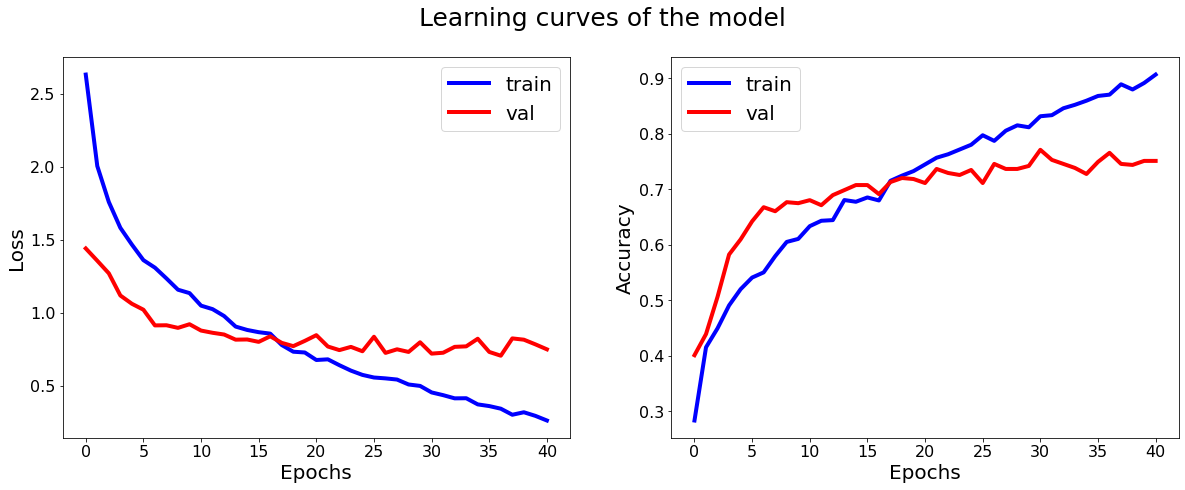

In [ ]:
# Learning curves
with plt.rc_context(params_dict):
    fig, ax = plt.subplots(1, 2, figsize = (20, 7))
    
    fig.suptitle("Learning curves of the model", fontsize = 25)
    ax[0].plot(history['loss'], label = "train", color = "blue")
    ax[0].plot(history['val_loss'], label = "val", color = "red")
    ax[0].legend(fontsize = 20)
    ax[0].set_xlabel("Epochs"); ax[0].set_ylabel("Loss")

    ax[1].plot(history['sparse_categorical_accuracy'], label = "train", color = "blue")
    ax[1].plot(history['val_sparse_categorical_accuracy'], label = "val", color = "red")
    ax[1].legend(fontsize = 20)
    ax[1].set_xlabel("Epochs"); ax[1].set_ylabel("Accuracy")
    plt.show()

Here we can see a confusion matrix of the prediction over the test set, in order to have a better understand of the accuracy of the model with respect all the different classes. 

The model is able to understand each class with a more difficulty with the class 0 (dendelion) and class 2 (tulips). In the end the model perform with a $\sim 77\%$ of accuracy.

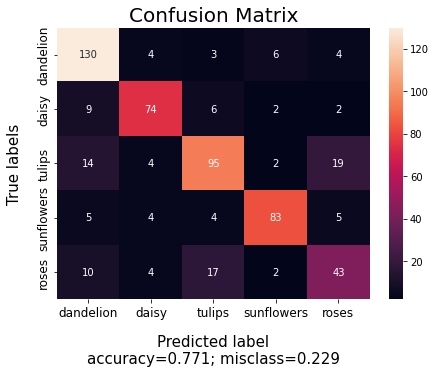

In [ ]:
y_pred = tf.math.argmax(tf.nn.softmax(logits = vggnet11.predict(test_ds_p, verbose = 0)), axis = -1)
y_true = tf.cast(tf.concat([y for x,y in iter(test_ds_p)], axis = 0), tf.int64)
acc = tf.reduce_mean(tf.cast(y_true == y_pred, tf.float32))

fig, ax = plt.subplots(figsize = (7,5))
cm = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel(f'Predicted label\naccuracy={acc:.3f}; misclass={1-acc:.3f}', fontdict = {'fontsize': 15}, labelpad = 15);
ax.set_ylabel('True labels', fontdict = {'fontsize': 15}, labelpad = 15)
ax.set_title('Confusion Matrix', fontdict = {'fontsize': 20})
ax.set_yticklabels(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], fontdict = {'fontsize': 12}) 
ax.set_xticklabels(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], fontdict = {'fontsize': 12});

Here instead I visualize a grid of image with the true label vs the predicted one, in a batch of 32 elements. Most of the images are correctly classified. 

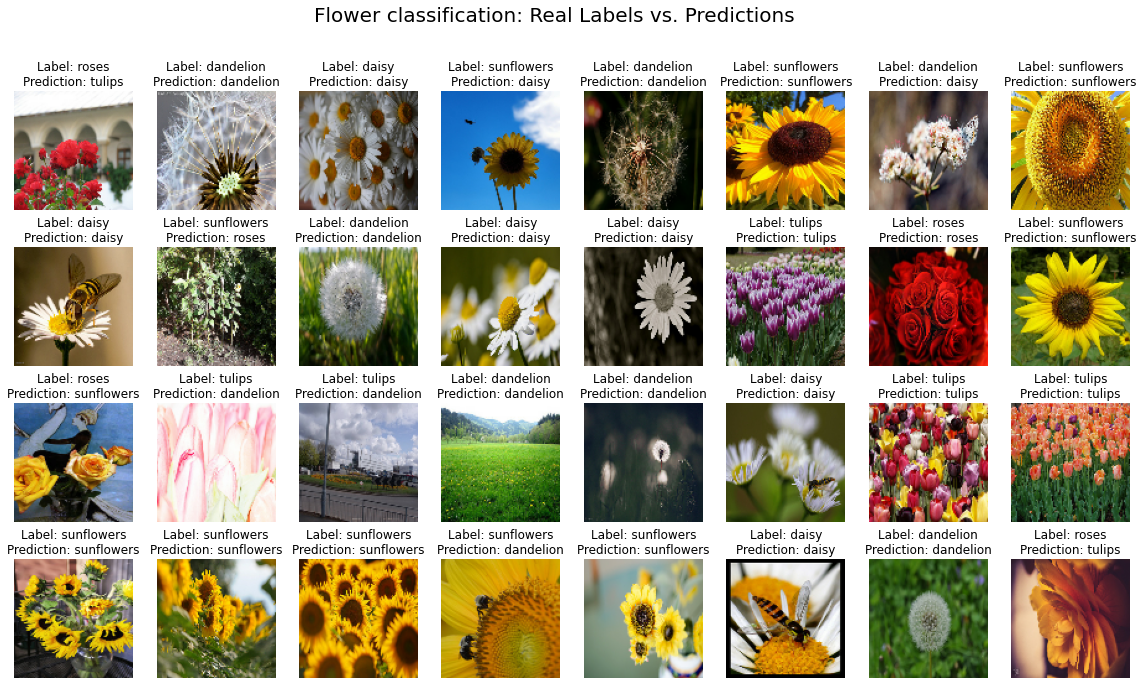

In [ ]:
# inspect some figure
plt.figure(figsize=(20, 11))
plt.suptitle('Flower classification: Real Labels vs. Predictions', fontsize = 20)
for i, (image, label) in enumerate(test_ds_p.take(32)):
  y_pred = vggnet11(image)
  y_pred = tf.math.argmax(tf.nn.softmax(logits = y_pred), axis = 1)
  # loop for plot
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image[0])
  plt.title(f'Label: {get_label_name(label[0])}\nPrediction: {get_label_name(y_pred[0])}')
  plt.axis("off")

### Adding modularity to the network



The variant I choose to implement is the **Early-exits** one. More specifically I add fixed early exits in the previous architecture and train the new model with a **Joint Cross Entropy** loss using all the early exit prediction and the final one. Inference is done by a **thresholding operation on the entropy** of the early exit layer $e$ that ensure if exit early or continue. The Early-Exit layer is a small classifier of two sequential layer: convolution and a fully connected one. The early exit branch are implemented after every convolutional block in the model, for a total of 5, in order to explore more this modular architecture.


Although would not be optimal in a production environment but is only for the purpose of exploration in the homework itself, the training is done by a monotoring on the validation accuracy (for stopping before overfitting) using a threshold of 0 (in order to consider accuracy only on the last exit during inference). In order to use the subclassing implementation of Tensorflow I need to enable the **dynamic computational graph** (static is the default one) setting `run_eagerly = True` in the compile. The overall training is done by using fit modifying the train and test step in order to retrieve usefull metrics. 

The inference is then done on the test set for different value of the threshold. For the same aim of exploration I will train two different models: one setting all the weighting parameter of the joint loss equal to 1 and one with all set to 0.3. 

References:

[1][Why should we add early exits
to neural networks?](https://arxiv.org/pdf/2004.12814.pdf)

[2][DeeBERT: Dynamic Early Exiting for Accelerating BERT Inference](https://arxiv.org/pdf/2004.12993.pdf)

[3][Going deeper with convolutions](https://arxiv.org/pdf/1409.4842.pdf )


First of all I will define a the Early Exit Branch and the Joint Loss using keras subclassing.

In [ ]:
class ExitBranch(tf.keras.layers.Layer):
    "Exit classifier branch"
    def __init__(self, num_classes):
      super(ExitBranch, self).__init__()
      self.classifier = tf.keras.Sequential([
        # convolution
        tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer = tf.keras.initializers.he_uniform,
                              activation = "relu"),
        # flattening (global pooling)
        tf.keras.layers.GlobalAvgPool2D(),
        # classifier
        tf.keras.layers.Dense(num_classes)
      ])
      
    def call(self, x, training=False):
      logits = self.classifier(x, training = training)
      return logits

In [ ]:
class JointCategoricalCrossentropy(tf.keras.losses.Loss):
    """
    Class definition of the Joint Loss for the CrossEntropy:
          L = CE(y, y_hat) + sum_e CE(y, y_e)
    """
    def __init__(self, lambda_exit):
      super().__init__()
      self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) 
      self.lambda_exit = lambda_exit
      self.num_exit = len(self.lambda_exit)

    def call(self, y_true, y_pred):
      
      loss = self.loss_fn(y_true, y_pred[0])
      for lambda_e, i in zip(self.lambda_exit, range(1, self.num_exit+1)):
          loss += lambda_e*self.loss_fn(y_true, y_pred[i])
          
      return loss

Here define a function in order to compute the entropy of the model. Optionally we can use also the confidence of the prediction as exit condition. 

Following I can define the new modular network.

In [ ]:
def entropy(logits):
    # Function to compute the Entropy H (and optionally the confidence p_e)
    
    probs = tf.nn.softmax(logits)
    # compute the entropy (normalized in [0,1])
    H = -tf.reduce_mean(probs * tf.math.log(probs), axis = -1)
    # get the confidence of exit e (as option for the exit condition)
    #p_e = tf.reduce_max(probs, axis = -1)
    return H

In [ ]:
# instantiate the losses
ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) 
# instantiate accuracy and loss trackers
num_exits = 6
accuracy_trackers = [tf.keras.metrics.SparseCategoricalAccuracy(name = f'accuracy_exit{i}') for i in range(1, num_exits+1)]
loss_tracker = tf.keras.metrics.Mean(name="loss")  

class ExitVGGnet11(tf.keras.Model):
    "Class for the model VGGNET11 with ExitBranch implemented using Keras Subclassing API"
    def __init__(self, num_classes, input_shape=(96, 96, 3), exit_threshold = 0.):
        super(ExitVGGnet11, self).__init__()

        # set the exit threshold for inference
        self.exit_threshold = exit_threshold

        # architecture layers
        self.conv_blocks = [
                add_ConvBlock(input_shape, n_conv_layers = 1, n_filters = 64, name="conv_block1"),
                add_ConvBlock((48, 48, 64), n_conv_layers = 1, n_filters = 128, name="conv_block2"),
                add_ConvBlock((24, 24, 128), n_conv_layers = 2, n_filters = 256, name="conv_block3"),
                add_ConvBlock((12, 12, 256), n_conv_layers = 2, n_filters = 512, name="conv_block4"),
                add_ConvBlock((6, 6, 512), n_conv_layers = 2, n_filters = 512, name="conv_block5")
              ]
        
        # add exit at the end of every convolution
        self.exit_layers = [ExitBranch(num_classes) for _ in range(len(self.conv_blocks))]

        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.fc1 = tf.keras.layers.Dense(4096, activation='relu', kernel_initializer = tf.keras.initializers.he_uniform)  
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(4096, activation='relu', kernel_initializer = tf.keras.initializers.he_uniform) 
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.classification = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=False):
        out = [] # list for storing the outputs {y_e}_e=1^{E+1}
        exit = 0 # initialize exit which are from 1 to E+1
        for conv_block, exit_e in zip(self.conv_blocks, self.exit_layers):
            exit += 1 # update the exit value
            x = conv_block(x, training=training)
            logits_e = exit_e(x, training=training)
            out.append(logits_e) # append the current exit prediction
            # compute stats
            H = entropy(logits_e)
            if not training and tf.math.less(H,self.exit_threshold):
                return logits_e, exit, H

        exit += 1 # update the exit value
        x = self.global_pool(x)
        x = self.dropout1(self.fc1(x), training = training)
        x = self.dropout2(self.fc2(x), training = training)
        logits = self.classification(x)
        out.append(logits)

        H = entropy(logits)
        if not training: # usual exit
            return logits, exit, H
        return out

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            logits = self(x, training=True) 
            loss = joint_cross_entropy(y, logits)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Compute our own metrics (and losses)
        # during the training I have and accuracy for every exit
        loss_tracker.update_state(loss)
        [tracker.update_state(y, logits[i]) for i, tracker in enumerate(accuracy_trackers)]

        trackers = {'loss': loss_tracker.result()}
        trackers.update({f"accuracy_exit{i+1}": tracker.result() for i,tracker in enumerate(accuracy_trackers)})
        return trackers

    def test_step(self, data):
        x, y = data
        logits, exit, _ = self(x, training=False)
        
        # Update the metrics.
        accuracy_trackers[0].update_state(y, logits)

        return {"accuracy": accuracy_trackers[0].result()}
        
    @property
    def metrics(self):
        return [loss_tracker, *accuracy_trackers]

In [ ]:
# define the optimizer: low learning rate for a smooth convergence
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)

def create_model(threshold = None):
    # clean the model creation
    tf.keras.backend.clear_session()
    # instantiate the model and compile it
    model = ExitVGGnet11(num_classes, exit_threshold = threshold)
    model.compile(optimizer=optimizer, run_eagerly = True)
    return model

Here I train the first model using weights $\lambda_e = 1$ $\forall e = 1, \ldots, E$.

In [ ]:
# define callback: Early Stopping 
early_stopping_callback  = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                            patience = 10,
                                                            restore_best_weights = True, 
                                                            verbose = 1)

# Instantiate the model
joint_cross_entropy = JointCategoricalCrossentropy(lambda_exit = [1., 1., 1., 1., 1. ])
model1 = create_model(threshold = 0.)
# ---------- TRAINING --------------------
tf.keras.utils.set_random_seed(1)
with tf.device('/GPU:0'):
    history = model1.fit(train_ds_p, validation_data=val_ds_p,
                        epochs=70, 
                        callbacks = [early_stopping_callback]) 
# ---------- SAVE -------------------------
with open(f'history_exitVggnet11_training1.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/70
81/81 [==============================] - 32s 386ms/step - loss: 10.2685 - accuracy_exit1: 0.1958 - accuracy_exit2: 0.2970 - accuracy_exit3: 0.3577 - accuracy_exit4: 0.4103 - accuracy_exit5: 0.4103 - accuracy_exit6: 0.3126 - val_accuracy: 0.4120
Epoch 2/70
81/81 [==============================] - 31s 381ms/step - loss: 8.4890 - accuracy_exit1: 0.2526 - accuracy_exit2: 0.4165 - accuracy_exit3: 0.4838 - accuracy_exit4: 0.5442 - accuracy_exit5: 0.5683 - accuracy_exit6: 0.4111 - val_accuracy: 0.4011
Epoch 3/70
81/81 [==============================] - 24s 293ms/step - loss: 7.8366 - accuracy_exit1: 0.3503 - accuracy_exit2: 0.4508 - accuracy_exit3: 0.5197 - accuracy_exit4: 0.5839 - accuracy_exit5: 0.6115 - accuracy_exit6: 0.4632 - val_accuracy: 0.5045
Epoch 4/70
81/81 [==============================] - 31s 381ms/step - loss: 7.3811 - accuracy_exit1: 0.3924 - accuracy_exit2: 0.4597 - accuracy_exit3: 0.5337 - accuracy_exit4: 0.6119 - accuracy_exit5: 0.6520 - accuracy_exit6: 0.5025 - 

Here I train a second model using weights $\lambda_e = 0.3$ $\forall e = 1, \ldots, E$. 

In [ ]:
joint_cross_entropy = JointCategoricalCrossentropy(lambda_exit = [0.3, 0.3, 0.3, 0.3, 0.3])
model2 = create_model(threshold = 0.)

# ---------- TRAINING --------------------
tf.keras.utils.set_random_seed(1)
with tf.device('/GPU:0'):
    history = model2.fit(train_ds_p, validation_data=val_ds_p,
                        epochs=70, 
                        callbacks = [early_stopping_callback]) 
# ---------- SAVE -------------------------
with open(f'history_exitVggnet11_training2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/70
81/81 [==============================] - 24s 294ms/step - loss: 4.6298 - accuracy_exit1: 0.2180 - accuracy_exit2: 0.2254 - accuracy_exit3: 0.2507 - accuracy_exit4: 0.3266 - accuracy_exit5: 0.3176 - accuracy_exit6: 0.2487 - val_accuracy: 0.3539
Epoch 2/70
81/81 [==============================] - 24s 294ms/step - loss: 3.9783 - accuracy_exit1: 0.2694 - accuracy_exit2: 0.2787 - accuracy_exit3: 0.4566 - accuracy_exit4: 0.5053 - accuracy_exit5: 0.4803 - accuracy_exit6: 0.3211 - val_accuracy: 0.4283
Epoch 3/70
81/81 [==============================] - 24s 291ms/step - loss: 3.7139 - accuracy_exit1: 0.3383 - accuracy_exit2: 0.3243 - accuracy_exit3: 0.5006 - accuracy_exit4: 0.5399 - accuracy_exit5: 0.5395 - accuracy_exit6: 0.3675 - val_accuracy: 0.5009
Epoch 4/70
81/81 [==============================] - 24s 291ms/step - loss: 3.5550 - accuracy_exit1: 0.3772 - accuracy_exit2: 0.3659 - accuracy_exit3: 0.5111 - accuracy_exit4: 0.5594 - accuracy_exit5: 0.5718 - accuracy_exit6: 0.3869 - v

Now following [2], I will compute the Expected Saving of the model when use different value of the threshold. This is a metric used by the author of the paper as a stable alternative to the inference runtime to capture efficiency. 

Following the code I also compute other statistics on the performance of the models and save it. The evaluation is done on the test set.

In [ ]:
def expected_savings(npreds_by_exit, num_exits):
    # Function to compute the Expected Saving as 
    # https://arxiv.org/pdf/2004.12993.pdf
    Ni = tf.cast(npreds_by_exit, tf.int32)
    n = num_exits

    num = tf.map_fn(
        lambda i: i * Ni[i-1], 
        tf.range(1, n+1, dtype=tf.int32), 
        fn_output_signature=(tf.int32))
  
    den = tf.map_fn(
        lambda i: n * Ni[i-1], 
        tf.range(1, n+1, dtype=tf.int32), 
        fn_output_signature=(tf.int32))
    return 1 - tf.reduce_sum(num)/tf.reduce_sum(den)

def nan_to_zero(tensor):
    # Function to convert NaN value to 0 (for visualization puourpose)
    return tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)

def inference_function(model, y_true, threshold_seq, name = None):
    # Function to perform inference step and return some statistic about the model
    # 1. Test Accuracy
    # 2. Accuracy by exit, Number of prediction by exit
    # 3. Expected Savings
    # return a dictionary with this object
    for threshold in threshold_seq:
        model.exit_threshold = threshold
        t_history = {}
        # predict over the test set and store inference time
        y_preds, exits, entropies = model.predict(test_ds_p, verbose = 0)
        # compute test accuracies
        is_correct = tf.cast(tf.argmax(y_preds, -1) == y_true, tf.float32)
        test_accuracy = tf.reduce_mean(is_correct)
        acc_by_exit = tf.map_fn(
            lambda i: tf.experimental.numpy.nanmean(is_correct[exits == i]), 
            tf.range(1, num_exits+1, dtype=tf.int64), 
            fn_output_signature=(tf.float32))
        npreds_by_exit = tf.map_fn(
            lambda i: tf.experimental.numpy.nansum(tf.cast(exits == i, tf.float32)), 
            tf.range(1, num_exits+1, dtype=tf.int64), 
            fn_output_signature=(tf.float32))
        # expected saving
        expected_saving = expected_savings(npreds_by_exit, num_exits)
        
        ## save the history file
        t_history['test_accuracy'] = test_accuracy
        t_history['expected_savings'] = expected_saving
        t_history['acc_by_exit'] = nan_to_zero(acc_by_exit)
        t_history['npreds_by_exit'] = nan_to_zero(npreds_by_exit)
        with open(f'history_exitVggnet11_{name}_{threshold}.pkl', 'wb') as f:
            pickle.dump(t_history, f)

In [ ]:
# retrieve true label
y_true = tf.cast(tf.concat([y for x,y in iter(val_ds_p)], axis = 0), tf.int64)
# define threshold sequence
threshold_seq = [0., 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.]
# compute the inference over the two different models
inference_function(model1, y_true, threshold_seq, name = 1)
inference_function(model2, y_true, threshold_seq, name = 2)

Here I just download all the different files created during the run of the notebook.

In [ ]:
!zip -r /content/training_histories.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.01.19/ (stored 0%)
  adding: content/.config/logs/2023.01.19/14.35.38.575339.log (deflated 53%)
  adding: content/.config/logs/2023.01.19/14.35.03.785196.log (deflated 86%)
  adding: content/.config/logs/2023.01.19/14.35.37.771945.log (deflated 54%)
  adding: content/.config/logs/2023.01.19/14.34.13.773307.log (deflated 92%)
  adding: content/.config/logs/2023.01.19/14.35.11.837697.log (deflated 54%)
  adding: content/.config/logs/2023.01.19/14.34.38.782289.log (deflated 53%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.con

In [ ]:
from google.colab import files
files.download("/content/training_histories.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✍ **RESULTS AND EVALUATION**

In order to visualize if the model is trained correctly I want to shows result of those models by:


*   looking at the performance of the model w/out early exit and see the contribution of a training with the regularized loss;
*   visualize how many prediction exited earlier togheter with the average accuracy of each early exit. 



I start with analyzing the performance of the model using the regularized loss and no early exit. All the inference is done by considering the prediction of the whole model.


I will refer to Model 1, the one using $\lambda_e = 1$, otherwise I will talk about Model 2 ($\lambda_e = 0.3$).



In [ ]:
with open(f"history_exitVggnet11_1_0.0.pkl", "rb") as handle:
    history1 = pickle.load(handle)

with open(f"history_exitVggnet11_2_0.0.pkl", "rb") as handle:
    history2 = pickle.load(handle)

no_ee_accuracy1 = history1['test_accuracy']
no_ee_accuracy2 = history2['test_accuracy']

print(f"The test accuracy of the EE model using lambda_e = 1 is: {no_ee_accuracy1*100:0.01f}%")
print(f"The test accuracy of the EE model using lambda_e = 0.3 is: {no_ee_accuracy2*100:0.01f}%")

The test accuracy of the EE model using lambda_e = 1 is: 76.0%
The test accuracy of the EE model using lambda_e = 0.3 is: 74.4%


We can see that both the model perform almost the same as the base one. But of course we need to go in depth understanding this performance. 

As we see from the plot below, with the model on the left we have a similar behaviour with respect the standard architecture, while using less weights (right plot) help the training to regularize more on the final exit.

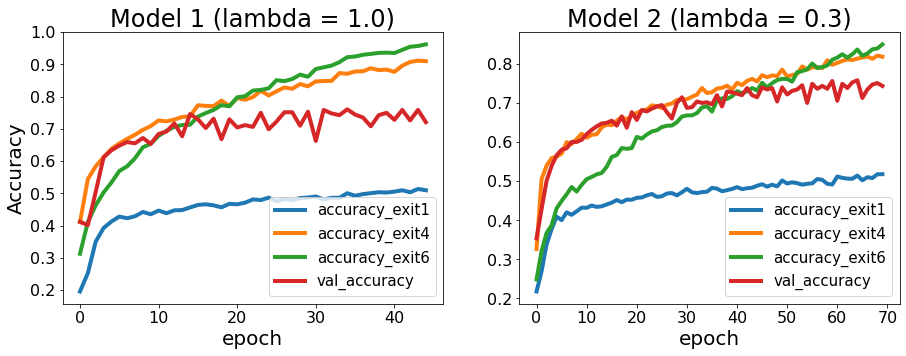

In [ ]:
with open(f"history_exitVggnet11_training1.pkl", "rb") as handle:
    history_train1 = pickle.load(handle)
with open(f"history_exitVggnet11_training2.pkl", "rb") as handle:
    history_train2 = pickle.load(handle)

names = ['accuracy_exit1', 'accuracy_exit4', 'accuracy_exit6', 'val_accuracy']
with plt.rc_context(params_dict):
    fig, axs = plt.subplots(1,2, figsize = (15,5))
    for name in names:
        axs[0].plot(history_train1[name], label = f"{name}")
        axs[1].plot(history_train2[name], label = f"{name}")
    axs[0].set_title("Model 1 (lambda = 1.0)"); axs[1].set_title("Model 2 (lambda = 0.3)")
    axs[0].set_xlabel("epoch"); axs[1].set_xlabel("epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(fontsize = 15)
    axs[1].legend(fontsize = 15)

In [ ]:
def plotting_function(threshold_seq = [0.05, 0.2, 0.3], path = None, no_ee_accuracy = None):
    # Function for plotting visualization

    # setting some parameters for the visualization pourpose 
    colors = ["red", "orange", "green"]
    props = dict(boxstyle='round', facecolor='white', alpha=0.3)
    x_axis = tf.range(1,7, dtype = tf.float32)

    with plt.rc_context(params_dict):
        fig, axs = plt.subplots(1,3, figsize = (17,5))
        axs = axs.flatten()
        plt.suptitle('Number of output samples by layer at vary the threshold', fontsize = 20, y = 1.05)

        for i,t in enumerate(threshold_seq):

            # load the dictionary with the saved information
            with open(f"{path}_{t}.pkl", "rb") as handle:
                history = pickle.load(handle) 

            # store the object of interest
            normalized_npreds_by_exit = history['npreds_by_exit'] / tf.reduce_sum(history['npreds_by_exit'])
            # plot the average number of prediction at each exit
            axs[i].bar(x_axis, normalized_npreds_by_exit, 
                  align='center', edgecolor = "black", linewidth = 3, width=0.35, label = "fraction of input",
                  color = colors[i])
            
            # add accuracy per exits over each bin
            accuracy_per_exits = history['acc_by_exit']
            rects = axs[i].patches
            for rect, label in zip(rects, accuracy_per_exits):
                height = rect.get_height()
                axs[i].text(
                    rect.get_x() + rect.get_width() / 2, height + 0.02, f"{label*100:.1f}%", ha="center", va="bottom", 
                    fontsize = 13, fontweight = 'bold'
                )

            accuracy = history['test_accuracy']
            expected_saving = history['expected_savings']
            # add a box and naming axis
            text = f"Threshold = {t}\nAccDrop = {(no_ee_accuracy-accuracy)/no_ee_accuracy *100:.1f}%\nSavings = {(expected_saving *100):.1f}%"
            axs[i].text(3.95, 1.05, text,  fontsize=15, verticalalignment='top', bbox=props)
            axs[i].set_xlabel('Exit Layer')
            axs[i].set_ylim([0,1.1])

        axs[0].set_ylabel('Fraction of dataset')
        fig.tight_layout();

In the following plot I want to show the fraction of samples exiting at each early branch at different value of the threshold. For every exit in bold there is the percentage of accuracy in each early exit, and a legend adding the Expected Saving metrics and the Accuracy drop with respect the baseline (threshold = 0). 

The first plot is reguarding the Model 1, the second below about Model 2. 

In general as the threshold increase, gradually more samples exit earlier. Looking at the first model, the performance are very good for the lowest threshold, increasing instead of decreasing the accuracy of the model (minus sign here measure increasing) and having a good amount of efficiency. Another good choice is the second threshold, here the exit are balanced like a uniform distribution, this efficiency came at the cost of an important accuracy drop that persist increasing the threshold from now on. 

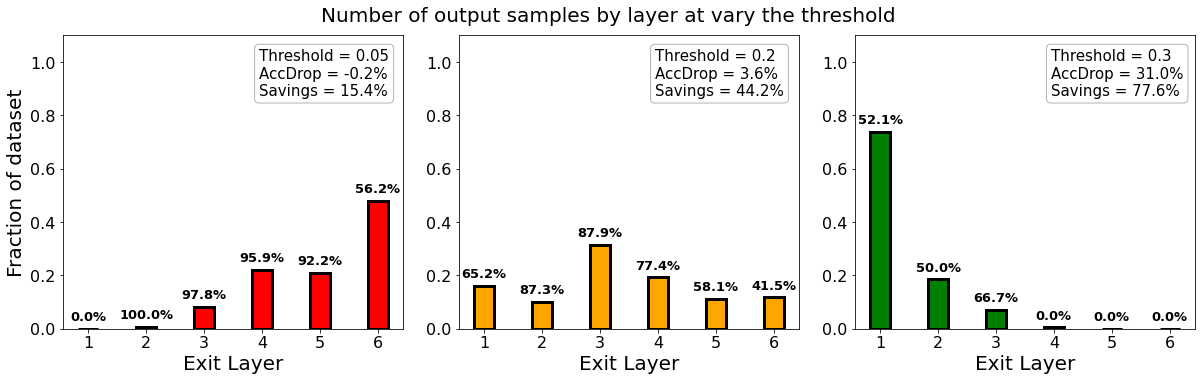

In [ ]:
plotting_function(path = "history_exitVggnet11_1", no_ee_accuracy = no_ee_accuracy1)

Here I show the second model with $\lambda_e = 0.3$. Comparing the two models, the lower weights increase the accuracy of the last exit for the lowest threhsold, at the cost of less efficiency. Despite all the same consideration can be repeated.

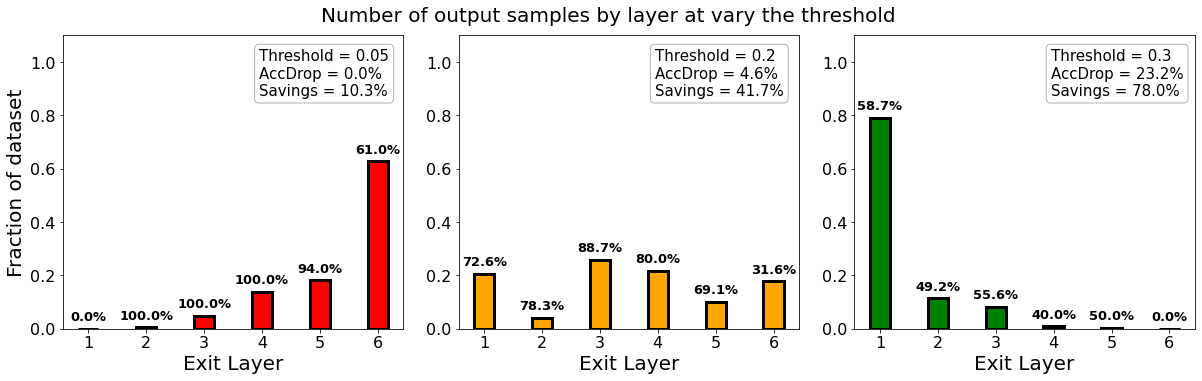

In [ ]:
plotting_function(path = "history_exitVggnet11_2", no_ee_accuracy = no_ee_accuracy2)